In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from yahoofinancials import YahooFinancials as YF
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [2]:
# Define the ticker and the time period
ticker = 'XOM'
start_date = '2019-01-01'
end_date = '2020-01-01'

# Fetch TSLA data
ticker_data = yf.Ticker(ticker)
data = ticker_data.history(start=start_date, end=end_date)

data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02 00:00:00-05:00,51.670386,53.603713,51.601341,53.465618,16727200,0.0,0.0
2019-01-03 00:00:00-05:00,53.703445,53.895243,52.445250,52.644722,13866100,0.0,0.0
2019-01-04 00:00:00-05:00,53.427255,54.677776,53.212442,54.585716,16043600,0.0,0.0
2019-01-07 00:00:00-05:00,54.662436,55.314548,54.271167,54.869576,10844200,0.0,0.0
2019-01-08 00:00:00-05:00,55.652109,55.690465,55.191795,55.268513,11439000,0.0,0.0


In [3]:
# Moving Average 
short_window = 40
long_window = 100

data['Short_MAvg'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
data['Long_MAvg'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

In [4]:
# Basic trading signal based on crossover 

# Create a 'Signal' column
data['Signal'] = 0
data['Signal'] = np.where(data['Short_MAvg'] > data['Long_MAvg'], 1, 0)

In [5]:
# Generate trading orders
data['Position'] = data['Signal'].diff()

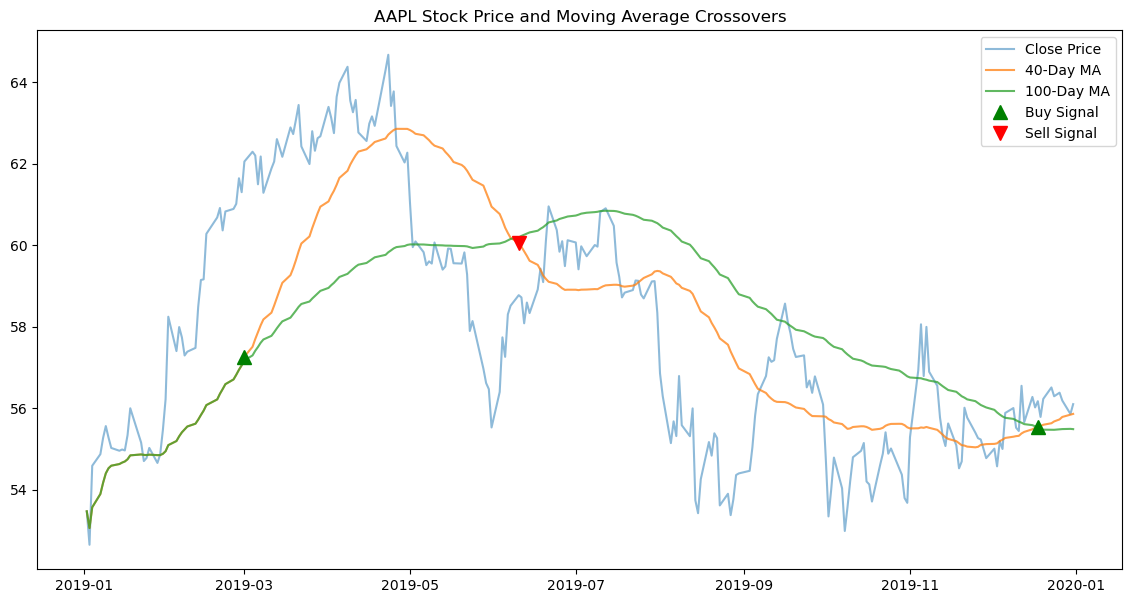

In [6]:
# Basic Back Test

# Plot the closing prices and moving averages
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.plot(data['Short_MAvg'], label=f'{short_window}-Day MA', alpha=0.75)
plt.plot(data['Long_MAvg'], label=f'{long_window}-Day MA', alpha=0.75)

# Plot buy signals
plt.plot(data[data['Position'] == 1].index, data['Short_MAvg'][data['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')

# Plot sell signals
plt.plot(data[data['Position'] == -1].index, data['Short_MAvg'][data['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('AAPL Stock Price and Moving Average Crossovers')
plt.legend()
plt.show()

In [7]:
data['Std_Dev'] = data['Close'].rolling(window=short_window, min_periods=1).std()

# Calculate the z-score
data['Z_Score'] = (data['Close'] - data['Short_MAvg']) / data['Std_Dev']

In [8]:
# Define thresholds for buying and selling
threshold_buy = -1.5  # Buy signal threshold
threshold_sell = 1.5  # Sell signal threshold

# Generate signals
data['Signal'] = 0
data['Signal'][data['Z_Score'] > threshold_sell] = -1  # Sell signal
data['Signal'][data['Z_Score'] < threshold_buy] = 1  # Buy signal

# Generate trading positions
data['Position'] = data['Signal'].replace(0, np.nan).ffill().fillna(0)

/var/folders/z3/mmqv83kn7gvb04yyy9l4n95w0000gn/T/ipykernel_7382/2099185115.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Z_Score'] > threshold_sell] = -1  # Sell signal
/var/folders/z3/mmqv83kn7gvb04yyy9l4n95w0000gn/T/ipykernel_7382/2099185115.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Z_Score'] < threshold_buy] = 1  # Buy signal


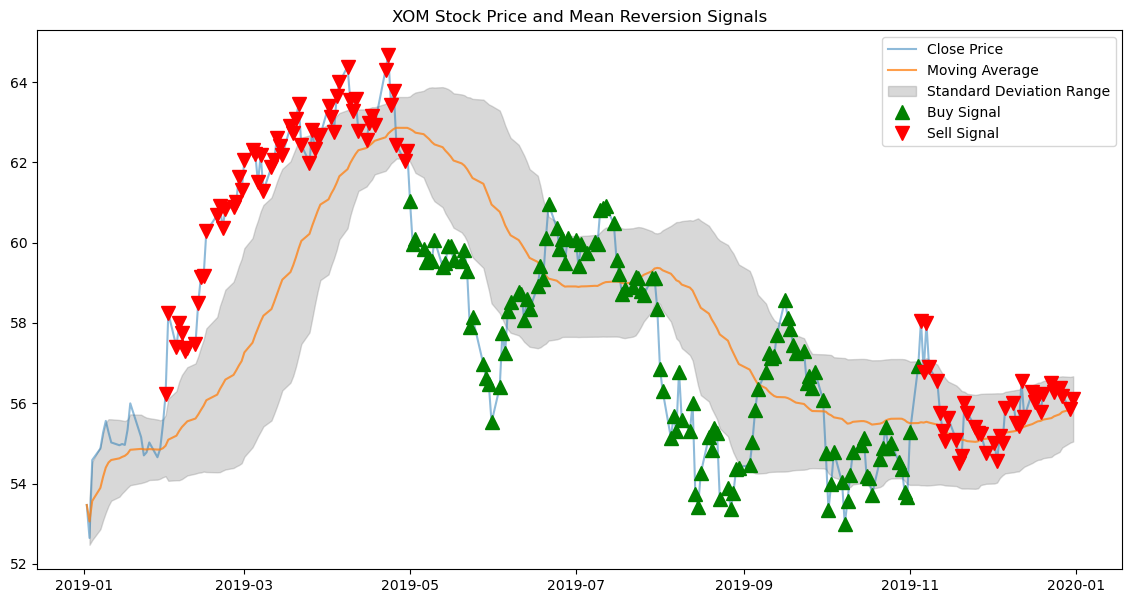

In [9]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.plot(data['Short_MAvg'], label='Moving Average', alpha=0.75)
plt.fill_between(data.index, data['Short_MAvg'] - data['Std_Dev'], data['Short_MAvg'] + data['Std_Dev'], color='gray', alpha=0.3, label='Standard Deviation Range')

# Highlight the buy and sell signals
plt.plot(data[data['Position'] == 1].index, data['Close'][data['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(data[data['Position'] == -1].index, data['Close'][data['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title(f'{ticker} Stock Price and Mean Reversion Signals')
plt.legend()
plt.show()

In [ ]:
# Calculate RSI
delta = data['Close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down

data['RSI'] = 100 - (100 / (1 + rs))

# Calculate TTM EPS and P/E
eps = ticker_data.get_earnings_dates(limit=60)
eps = eps[(eps.index >= (data.index[0]-relativedelta(years=1))) & (eps.index <= data.index[-1])]
eps = eps.iloc[::-1]
eps['TTM'] = eps['Reported EPS'].rolling(window=4).sum()
eps.index = eps.index.date
idx = pd.date_range(eps.index[0], eps.index[-1])
eps = eps.reindex(idx.date, fill_value=np.nan)
data.index = data.index.date
data['TTM_EPS'] = eps['TTM'].copy()
data[data['TTM_EPS'].notna()]
data['TTM_EPS'] = data['TTM_EPS'].ffill()
data['TTM_EPS'] = data['TTM_EPS'].fillna(eps['TTM'].loc[eps['TTM'].notna()].iloc[0])
data['TTM_P/E'] = data['Close'] / data['TTM_EPS']

data

## Model Analysis

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

ticker = 'TSLA'
start_date = '2010-01-01'
end_date = '2020-01-01'

model = LogisticRegression()

data = yf.download(ticker, start=start_date, end=end_date)

# Calculate moving averages and std
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['Std_Dev'] = data['Close'].rolling(window=20).std()

# Calculate the z-score
data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

# Calculate RSI
delta = data['Close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down

data['RSI'] = 100 - (100 / (1 + rs))

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# Drop any NaNs
data.dropna(inplace=True)

# If stock price goes up or down
data['Target'] = (data['Returns'].shift(-1) > 0).astype(int)

# Wanted features for X and y
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Returns']
X = data[features]
y = data['Target']

# Split data into first 80% and last 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate cumulative strategy returns on test data
X_test['Predicted_Signal'] = y_pred
X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
cumulative_strategy_returns = (X_test['Strategy_Returns'] + 1).cumprod()

# Calculate cumulative returns for the market
spy = yf.download('SPY', start=X_test.index[0].date().strftime('%Y-%m-%d'), end=end_date)
spy['Returns'] = spy['Close'].pct_change()
cumulative_market_returns = (spy['Returns'] + 1).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cumulative_strategy_returns, label='Strategy Returns')
plt.plot(cumulative_market_returns, label='Market Returns')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def train(model, ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Calculate moving averages and std
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['Std_Dev'] = data['Close'].rolling(window=20).std()

    # Calculate the z-score
    data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

    # Calculate RSI
    delta = data['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up / ema_down

    data['RSI'] = 100 - (100 / (1 + rs))

    # Calculate the daily returns
    data['Returns'] = data['Close'].pct_change()

    # Drop any NaNs
    data.dropna(inplace=True)

    # If stock price goes up or down
    data['Target'] = (data['Returns'].shift(-1) > 0).astype(int)

    # Wanted features for X and y
    features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Returns']
    X = data[features]
    y = data['Target']

    # Split data into first 80% and last 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate cumulative strategy returns on test data
    X_test['Predicted_Signal'] = y_pred
    X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
    cumulative_strategy_returns = (X_test['Strategy_Returns'] + 1).cumprod()

    # Calculate cumulative returns for the market
    spy = yf.download('SPY', start=X_test.index[0].date().strftime('%Y-%m-%d'), end=end_date)
    spy['Returns'] = spy['Close'].pct_change()
    cumulative_market_returns = (spy['Returns'] + 1).cumprod()
    
    plt.figure(figsize=(10,5))
    plt.plot(cumulative_strategy_returns, label='Strategy Returns')
    plt.plot(cumulative_market_returns, label='Market Returns')
    plt.legend()
    plt.show()

In [ ]:
#| code-fold: true
%load_ext autoreload
%autoreload 2
from strategy import MeanReversion

In [ ]:
ticker = 'TSLA'
market = 'SPY'
start = '2014-01-01'
end = '2024-01-01'
MR = MeanReversion(ticker, start, end, market)

In [ ]:
RF = RandomForestClassifier(n_estimators=100, random_state=42)
X_test = MR.evaluate(model=RF)

In [ ]:
LR = LogisticRegression()
X_test = MR.evaluate(model=LR)

In [ ]:
SVM = SVC()
X_test = MR.evaluate(model = SVM)

Note: Different models work better for different stocks.

Below is code to calculate risk free rate. Used for calculating sharpe ratio.

In [ ]:
def deannualize(annual_rate, periods=365):
    return (1 + annual_rate) ** (1/periods) - 1

def get_risk_free_rate(start_date, end_date):
    # download 3-month us treasury bills rates
    annualized = yf.download('^IRX', start_date, end_date)['Close']
    annualized = annualized / 100
    
    # de-annualize
    daily = annualized.apply(deannualize)

    # create dataframe
    return pd.DataFrame({"annualized": annualized, "daily": daily})

## Pytrends

In [ ]:
from pytrends.request import TrendReq
from pytrends import dailydata

In [ ]:
pytrends = TrendReq(hl = 'en-US', tz=360)

In [ ]:
pytrends.build_payload(kw_list=['Microsoft', 'Tesla', 'Apple'], timeframe='2010-01-01 2020-01-01')

## Basket Analysis

In [10]:
tickers = ['XOM', 'CVX', 'COP', 'NEE', 'SO', 'EOG', 'DUK', 'MPC', 'SLB', 'PSX']

def prepare_data(tickers, start_date, end_date):
    '''
    Combines data of all tickers into a single dataframe for X_train. X_test is a list of dataframes for each ticker.
    '''
    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []
    for t in tickers:
        data = yf.download(t, start=start_date, end=end_date)
        # Calculate moving averages and std
        data['SMA_20'] = data['Close'].rolling(window=20).mean()
        data['SMA_50'] = data['Close'].rolling(window=50).mean()
        data['Std_Dev'] = data['Close'].rolling(window=20).std()

        # Calculate the z-score
        data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

        # Calculate RSI
        delta = data['Close'].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ema_up = up.ewm(com=13, adjust=False).mean()
        ema_down = down.ewm(com=13, adjust=False).mean()
        rs = ema_up / ema_down

        data['RSI'] = 100 - (100 / (1 + rs))

        # Calculate the daily returns
        data['Returns'] = data['Close'].pct_change()

        # Drop any NaNs
        data.dropna(inplace=True)

        # If stock price goes up or down
        data['Target'] = (data['Returns'].shift(-1) > 0).astype(int)
        data['Ticker'] = t
        features = ['Ticker', 'SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Returns']
        X = data[features]
        y = data['Target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_test_list.append(X_test)
        y_test_list.append(y_test)

    return pd.concat(X_train_list, ignore_index=True), pd.concat(y_train_list, ignore_index=True), X_test_list, y_test_list

In [ ]:
def evaluate(model, X_test_, y_test_, features, market_data):
    '''
    Compares returns to the market for a single ticker.
    '''
    X_test = X_test_.copy()
    y_test = y_test_.copy()
    
    y_pred = model.predict(X_test[features])
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{X_test.Ticker.iloc[0]} Accuracy:", accuracy)

    # Calculate cumulative strategy returns on test data
    X_test['Predicted_Signal'] = y_pred
    X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
    cumulative_strategy_returns = (X_test['Strategy_Returns'].fillna(0) + 1).cumprod()
    returns = X_test.loc[X_test.index, 'Returns']
    returns.iloc[0] = 0
    cumulative_stock_returns = (returns + 1).cumprod()

    # Calculate cumulative returns for the market
    market_data['Returns'] = market_data['Close'].pct_change()
    #cumulative_market_returns = (market_data['Returns'].fillna(0) + 1).cumprod()

    plt.figure(figsize=(10,5))
    plt.plot(cumulative_strategy_returns, label='Strategy Returns', alpha=0.5)
    #plt.plot(cumulative_market_returns, label='Market Returns')
    plt.plot(cumulative_stock_returns, label='Stock Returns', alpha=0.5)
    plt.title(f'{X_test.Ticker.iloc[0]} Returns')
    plt.legend()
    plt.show()

    return X_test

In [11]:
start = '2014-01-01'
end = '2024-01-01'
X_train, y_train, X_test, y_test = prepare_data(tickers, start, end)

[*********************100%%**********************]  1 of 1 completed


NameError: name 'train_test_split' is not defined

In [ ]:
from sklearn.svm import LinearSVC

#model = RandomForestClassifier(n_estimators=100, random_state=42)
model = SVC()
#model = LogisticRegression()
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Returns']
model = model.fit(X_train[features], y_train)

market_data = yf.download('SPY', start=start, end=end)
X_test_vec = []

for i in range(10):
    market = market_data[market_data.index >= X_test[i].index[0]].copy()
    X_test_vec.append(evaluate(model, X_test[i], y_test[i], features, market_data=market))

In [ ]:
X_test_vec[0]['Predicted_Signal'].mean()

## Feature Selection

### RFE

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI']
rfe = RFECV(LinearSVC(dual='auto'), cv = 5)

In [ ]:
rfe = rfe.fit(X_train[features], y_train)

In [ ]:
rfe.ranking_

In [ ]:
market_data = yf.download('SPY', start=start, end=end)
market = market_data[market_data.index >= X_test[i].index[0]].copy()
X_test_vec = []
for i in range(10):
    X_test_vec.append(evaluate(rfe, X_test[i], y_test[i], features, market_data=market))

## LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable 

In [ ]:
%load_ext autoreload
%autoreload 2
from lstm_model import LSTMModel

In [ ]:
ticker = 'XOM'
start_date = '2014-01-01'
end_date = '2024-01-01'

#model = LogisticRegression()

data = yf.download(ticker, start=start_date, end=end_date)

# Calculate moving averages and std
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['Std_Dev'] = data['Close'].rolling(window=20).std()

# Calculate the z-score
data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

# Calculate RSI
delta = data['Close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down

data['RSI'] = 100 - (100 / (1 + rs))

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# If stock price goes up or down
data['Target'] = data['Close'].shift(-1)

data.dropna(inplace=True)

# Wanted features for X and y
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Close', 'Returns']
X = data.loc[:, features]
y = data.iloc[:, (data.shape[1]-1):(data.shape[1])]

from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm1 = MinMaxScaler()
ss1 = StandardScaler()
# mm2 = MinMaxScaler()
# ss2 = StandardScaler()

X_ss = pd.DataFrame(ss1.fit_transform(X), index=X.index, columns=X.columns)
y_mm = pd.DataFrame(mm1.fit_transform(y), index=y.index, columns=y.columns)

# Split data into first 80% and last 20%
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size=0.2, random_state=42, shuffle=False)
# X_train_ss = pd.DataFrame(ss1.fit_transform(X_train), index=X_train.index, columns=X.columns)
# y_train_mm = pd.DataFrame(mm1.fit_transform(y_train), index=y_train.index, columns=y.columns)
# X_test_ss = pd.DataFrame(ss2.fit_transform(X_test), index=X_test.index, columns=X.columns)
# y_test_mm = pd.DataFrame(mm2.fit_transform(y_test), index=y_test.index, columns=y.columns)

In [ ]:
features_ = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI']
X_train_tensors = Variable(torch.Tensor(np.array(X_train[features_])))
X_test_tensors = Variable(torch.Tensor(np.array(X_test[features_])))

y_train_tensors = Variable(torch.Tensor(y_train.values))
y_test_tensors = Variable(torch.Tensor(y_test.values))

X_train_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [ ]:
print("Training Shape", X_train_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_final.shape, y_test_tensors.shape) 

In [ ]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [ ]:
lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers, X_train_final.shape[1]) #our lstm class 

In [ ]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
  outputs = lstm.forward(X_train_final) #forward pass
  optimizer.zero_grad() #calculate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

In [ ]:
train_predict = lstm(X_train_final)
data_predict = train_predict.data.numpy()

In [ ]:
data_predict = mm1.inverse_transform(data_predict) #reverse transformation

In [ ]:
X_train = pd.DataFrame(ss1.inverse_transform(X_train), index=X_train.index, columns=features)

In [ ]:
X_train['Predicted_Price'] = data_predict
X_train['Actual_Signal'] = (X_train['Returns'].shift(-1) > 0).astype(int)
X_train['Predicted_Returns'] = X_train['Predicted_Price'].pct_change()
X_train['Predicted_Signal'] = (X_train['Predicted_Returns'].shift(-1) > 0).astype(int)
X_train['Strategy_Returns'] = X_train['Returns'] * X_train['Predicted_Signal'].shift(1)
cumulative_strategy_returns = (X_train['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_train.loc[X_train.index, 'Returns']
returns.iloc[0] = 0
cumulative_stock_returns = (returns + 1).cumprod()
accuracy = (X_train['Actual_Signal'] == X_train['Predicted_Signal']).mean()
print(f'Accuracy: {accuracy}')
# Calculate cumulative returns for the market
#market_data['Returns'] = market_data['Close'].pct_change()
#cumulative_market_returns = (market_data['Returns'].fillna(0) + 1).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cumulative_strategy_returns, label='Strategy Returns', alpha=0.5)
#plt.plot(cumulative_market_returns, label='Market Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns', alpha=0.5)
plt.legend();

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(X_train['Predicted_Price'], label='Predicted Price')
plt.plot(X_train['Close'], label='Actual Price')
plt.legend();

In [ ]:
test_predict = lstm(X_test_final)
data_predict = test_predict.data.numpy()

In [ ]:
data_predict = mm1.inverse_transform(data_predict)
X_test = pd.DataFrame(ss1.inverse_transform(X_test), index=X_test.index, columns=features)

In [ ]:
X_test['Actual_Signal'] = (X_test['Returns'].shift(-1) > 0).astype(int)
X_test['Predicted_Price'] = data_predict
X_test['Predicted_Returns'] = X_test['Predicted_Price'].pct_change()
X_test['Predicted_Signal'] = (X_test['Predicted_Returns'].shift(-1) > 0).astype(int)
X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
cumulative_strategy_returns = (X_test['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_test.loc[X_test.index, 'Returns']
returns.iloc[0] = 0
cumulative_stock_returns = (returns + 1).cumprod()
accuracy = (X_test['Actual_Signal'] == X_test['Predicted_Signal']).mean()
print(f'Accuracy: {accuracy}')
# Calculate cumulative returns for the market
#market_data['Returns'] = market_data['Close'].pct_change()
#cumulative_market_returns = (market_data['Returns'].fillna(0) + 1).cumprod()

plt.figure(figsize=(10,5))

plt.plot(cumulative_strategy_returns, label='Strategy Returns')
#plt.plot(cumulative_market_returns, label='Market Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns')
plt.legend();

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(X_test['Predicted_Price'], label='Predicted Price')
plt.plot(X_test['Close'], label='Actual Price')
plt.legend();